### **1. Introduction & Roadmap**

**Where we’re coming from (NB02 in one line):**
In **NB02**, we framed forecasting as **one-step ahead**:
$$
X_t = [T_{t-S+1}, \dots, T_t] \;\longrightarrow\; \hat T_{t+1},
$$
with a window length $S=7$ (7 days of history), using **batch-first** tensors $(B,S,1)$ and small CPU-friendly models (RNN/LSTM/GRU).

**What we’re doing in this NB:**
We extend the task to **multi-step forecasting**: given the same 7-day window, we want the **next $H$** days:
$$
X_t \;\longrightarrow\; \hat{\mathbf{y}}_t
= [\hat T_{t+1}, \hat T_{t+2}, \dots, \hat T_{t+H}] \in \mathbb{R}^{H}.
$$

- We will **keep shapes student-friendly**: inputs $(B,S,1)$, outputs:
  - **Recursive strategy:** produce $H$ scalars step by step, then stack to $(B,H)$ for evaluation.
  - **Direct strategy:** predict all $H$ values **at once** as a vector $(B,H)$.

What we’ll **compare**
1) **Recursive (autoregressive) rollout**  
   We **reuse our NB02 single-step models** $f$. Starting from the last $S$ truths, we predict $\hat T_{t+1}$, then **append our own prediction** to the window, slide, and predict $\hat T_{t+2}$, and so on up to $H$ steps.

2) **Direct multi-output head**  
   We train a model $g$ whose readout maps the last hidden state to an $H$-dimensional vector (one shot). This avoids step-by-step feedback of our own predictions.

> We will **not** decide which one is “best” in theory; we’ll let **data + metrics** (per-horizon MAE/RMSE) guide us.

What we’ll **reuse** vs **rebuild**
- **Reuse (from NB02):**
  - The **model classes** (RNN/LSTM/GRU) and, if available, the **saved weights** (`state_dict` files) in `./artifacts/`.
  - Our **batch-first** convention $(B,S,1)$ and small hidden sizes.

- **Rebuild (in this notebook):**
  - **Data pipeline** end-to-end: load CSV → **time-aware split** (train 1981–1988, test 1989–1990) → **scaler** fit on **train only** → transform train/test.
  - **Multi-step targets** (windows $\rightarrow$ vectors of length $H$) for evaluation.
  - A **Direct** model (e.g., GRU-Direct) trained briefly on CPU.

**Constraints (so our runs stay fast and reproducible)**
- **CPU-only** execution (no GPU assumptions).  
- **Short runs**: modest epochs (e.g., 15–25), small **hidden size** (e.g., 64), batch-first $(B,S,1)$.  
- **Deterministic seeds** where possible.  
- **No leakage**: we split by **time first**, then **fit scaler on train** only.

**How we’ll evaluate (high-level plan)**
- We’ll compute **MAE/RMSE per horizon** $k=1,\dots,H$ **in °C** (by inverse-transforming with the same train-fitted scaler).  
- We’ll include **simple baselines** (persistence, 7-day mean) to anchor difficulty.  
- We’ll **plot error vs horizon** and inspect a few **actual vs forecast** slices (steady vs turning segments).

**Roadmap for NB03 (what’s coming next)**
1. **Data loading + split + scaling** (self-contained refresh).  
2. **Framing & builders** for multi-step windows/targets (no leakage across the split).  
3. **Baselines** (persistence, 7-day mean) per horizon.  
4. **Recursive** rollout using NB02 models (RNN/LSTM/GRU).  
5. **Direct** multi-output model (e.g., GRU-Direct) with quick training.  
6. **Side-by-side** comparison + quick error analysis.  
7. **Save minimal artifacts** (best model weights) and wrap up.

**Reflection (think before we code)**
- Why do multi-step errors usually **grow with horizon** $k$?  
  *Hint:* in **Recursive**, early mistakes are **fed back** into the input (compounding). In **Direct**, later horizons are inherently **harder** (further from observed context).  
- Given our daily temperatures and $S=7$, where do we expect the **largest misses**—at **peaks**, **troughs**, or **transition** periods? Why?


**What to notice in the sanity check**
- **Shapes** match our convention: we fed a window shaped as $(1, S, 1)$, and each model returned $(1, 1)$.  
- The **predictions are in °C** after inverse scaling (we trained on scaled values, but we **always report** in degrees for interpretation).  
- If weights were **not found**, we see a warning—this is fine for now; we’ll still be able to demonstrate the **recursive** and **direct** strategies (and we can re-train quickly if needed).

In the next section, we will **frame the multi-step problem** carefully (recursive vs direct), and then we’ll **prepare the data** for multi-step targets.

---

#### **2. Data Loading, Time Split, and Scaling (self-contained)**

**What we’ll set up (and why)**

In this section we prepare the **entire data pipeline** that all later sections depend on:

1. **Load the CSV** with **strict** date parsing and use the date as the **index** (so time-aware ops are easy and safe).
2. Make a **time-aware split**:  
   - **Train:** 1981-01-01 → 1988-12-31  
   - **Test:** 1989-01-01 → 1990-12-31  
   Splitting by calendar time prevents **future data** from leaking into training.
3. **Keep the daily calendar intact.** Dropping rows with missing values would “compress” time. Instead, we:
   - **Reindex** to a complete daily grid, then  
   - **Impute** missing temps **per split** (train and test **separately**) using time-based linear interpolation.  
     This avoids leakage across the split and keeps seasonality aligned with the calendar.
4. **Scale** with a **train-only fit** of `MinMaxScaler` to the range $[0,1]$:  
   $$
   x' \;=\; \frac{x - \min(\text{train})}{\max(\text{train}) - \min(\text{train})}.
   $$
   We then **transform** both train and test using those train parameters.

We’ll stick to our **batch-first** convention from NB02 so the model inputs later have shape **$(B, S, 1)$**, where by default **$S=7$** (7 days of history) and we’ll later forecast **$H=7$** days ahead.

> **Note.** After scaling on train, it’s normal if **test** scaled values fall slightly **outside** $[0,1]$. That simply means the test years contain temps outside the train’s min/max — a realistic distribution shift, not leakage.

**Pipeline (at a glance)**

```text
CSV → strict date parse → set Date index → reindex to daily grid
└─> split by time (train | test) ─> interpolate per split (no leakage)
└─> fit MinMax on TRAIN only ─> transform TRAIN & TEST
```

In [1]:
# --- Imports & notebook defaults (self-contained) ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Window/horizon defaults for NB03 (we’ll reuse these later)
S = 7  # history window length
H = 7  # forecast horizon

DATA_PATH = "dataset/1_Daily_minimum_temps.csv"
print(f"[NB03] Defaults: S={S}, H={H}")


[NB03] Defaults: S=7, H=7


In [2]:
# --- Load CSV with strict date parsing & numeric Temp ---
# The file uses MM/DD/YY, e.g., 01/13/81 = Jan 13, 1981
df = pd.read_csv(DATA_PATH)
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")  # strict format
df["Temp"] = pd.to_numeric(df["Temp"], errors="coerce")     # coerce bad entries to NaN
df = df.set_index("Date").sort_index()

print("Raw shape (rows, cols):", df.shape)
display(df.head(5))
display(df.tail(5))

# Sanity: is the index monotonic by time?
print("Date index monotonic increasing? ->", df.index.is_monotonic_increasing)


Raw shape (rows, cols): (3650, 1)


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


,Temp
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


Date index monotonic increasing? -> True


In [3]:
# --- Keep the daily calendar intact: reindex to complete daily grid ---
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(full_idx)
df.index.name = "Date"

missing_total = int(df["Temp"].isna().sum())
print(f"Missing days after reindex (before imputation): {missing_total}")

# Quick peek around any missing spots (optional)
# df[df["Temp"].isna()].head()


Missing days after reindex (before imputation): 5


In [4]:
# --- Time-aware split: Train (1981–1988) vs Test (1989–1990) ---
split_date = pd.Timestamp("1989-01-01")  # test starts here

df_train = df.loc[: split_date - pd.Timedelta(days=1)].copy()
df_test  = df.loc[split_date :].copy()

print(f"Train range: {df_train.index.min().date()} → {df_train.index.max().date()} | rows={len(df_train)}")
print(f" Test range: {df_test.index.min().date()}  → {df_test.index.max().date()}  | rows={len(df_test)}")
print("Missing in train BEFORE impute:", int(df_train['Temp'].isna().sum()))
print("Missing in test  BEFORE impute:", int(df_test['Temp'].isna().sum()))


Train range: 1981-01-01 → 1988-12-31 | rows=2922
 Test range: 1989-01-01  → 1990-12-31  | rows=730
Missing in train BEFORE impute: 5
Missing in test  BEFORE impute: 0


In [5]:
# --- Impute per split (no cross-split peeking) using time-based interpolation ---
# 'method="time"' uses the DatetimeIndex; 'limit_direction="both"' fills edges within each split safely.
df_train["Temp"] = df_train["Temp"].interpolate(method="time", limit_direction="both")
df_test["Temp"]  = df_test["Temp"].interpolate(method="time",  limit_direction="both")

print("Missing in train AFTER  impute:", int(df_train['Temp'].isna().sum()))
print("Missing in test  AFTER  impute:", int(df_test['Temp'].isna().sum()))

# Optional: preview ends to verify continuity
display(df_train.head(3)); display(df_train.tail(3))
display(df_test.head(3));  display(df_test.tail(3))

Missing in train AFTER  impute: 0
Missing in test  AFTER  impute: 0


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8


,Temp
Date,
1988-12-29,14.8
1988-12-30,14.1
1988-12-31,14.1


,Temp
Date,
1989-01-01,14.3
1989-01-02,17.4
1989-01-03,18.5


,Temp
Date,
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


In [6]:

# --- Fit MinMaxScaler on TRAIN ONLY (no leakage), then transform both splits ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df_train[["Temp"]])                 # train-only fit

train_scaled = scaler.transform(df_train[["Temp"]])  # ndarray (N_train, 1)
test_scaled  = scaler.transform(df_test[["Temp"]])   # ndarray (N_test, 1)

print("Scaled range (TRAIN) min/max:", float(train_scaled.min()), float(train_scaled.max()))
print("Scaled range (TEST)  min/max:", float(test_scaled.min()),  float(test_scaled.max()))

# print shape of scaled arrays
print("Scaled TRAIN shape (rows, cols):", train_scaled.shape)
print("Scaled  TEST shape (rows, cols):", test_scaled.shape)

Scaled range (TRAIN) min/max: 0.0 1.0
Scaled range (TEST)  min/max: 0.019011406844106463 0.8403041825095058
Scaled TRAIN shape (rows, cols): (2922, 1)
Scaled  TEST shape (rows, cols): (730, 1)


In [7]:
# what if we flatten the arrays? Will need this later
print("Scaled TRAIN shape:", train_scaled[:5])
print("Scaled TRAIN shape - flattened:", train_scaled.reshape(-1)[:5])

Scaled TRAIN shape: [[0.78707224]
 [0.68060837]
 [0.7148289 ]
 [0.55513308]
 [0.60076046]]
Scaled TRAIN shape - flattened: [0.78707224 0.68060837 0.7148289  0.55513308 0.60076046]


**What we just ensured**
- We **did not drop days**: the time axis remains a **true daily** calendar, so a 7-step window really means **7 consecutive days**.
- We **split by time** first, then **imputed within each split**. No values from the **future** helped fill gaps in the **past**.
- We **fit the scaler on train only**, then transformed both splits. This prevents **data leakage** via scaling parameters.
- We confirmed shapes and date ranges. We’re now ready to build **sliding windows** in $(B, S, 1)$ and set up **multi-step targets** of length $H$.

**Reflection**
- Why would dropping missing days **distort** seasonality and window semantics?  
  *Because it “compresses” the calendar; a 7-step window may no longer represent 7 consecutive days.*
- Why must we **fit** the scaler on **train only** and **apply** it to test?  
  *Because the scaler’s parameters (min/max) would otherwise be influenced by **future** data — a subtle form of leakage that makes reported errors unrealistically low.*
- Why can **test** scaled values sometimes be **outside** $[0,1]$?  
  *Train defines the min/max. If test years contain temperatures outside that range, the scaled numbers reflect this shift — that’s expected and honest.*

  ---

### **3. Framing Multi-Step Forecasting (intuition + math + builders)**

**From one-step to multi-step (what changes?)**
In NB02, we predicted **one day ahead**:
$$
X_t = [T_{t-S+1}, \dots, T_t] \;\longrightarrow\; \hat T_{t+1}.
$$

In NB03, we predict a **vector** of the next \(H\) days:
$$
X_t \;\longrightarrow\; \hat{\mathbf{y}}_t
= [\hat T_{t+1},\, \hat T_{t+2},\, \dots,\, \hat T_{t+H}] \in \mathbb{R}^{H}.
$$

We will compare two families:

- **Recursive (autoregressive)** — reuse our **NB02 single-step** model $f$ repeatedly  
  $$
  \hat T_{t+1} = f(X_t),\quad
  \hat T_{t+2} = f([T_{t-S+2},\dots,T_t,\hat T_{t+1}]),\ \dots
  $$
  Pros: easy reuse. Cons: **exposure bias / compounding error**.

- **Direct (multi-output)** — train a model $g$ that outputs all $H$ steps at once  
  $$
  [\hat T_{t+1}, \dots, \hat T_{t+H}] \;=\; g(X_t) \;=\; W\,h_{\text{last}} + b.
  $$
  Pros: avoids step-by-step drift. Cons: harder target, bigger head.

**Summary:**

> **Recursive**</br>
Input $(B, S, 1)$ --$f$--> $\hat{y}_{t+1}$  
slide + append $\hat{y}_{t+1}$ → $(B, S, 1)$ --$f$--> $\hat{y}_{t+2}$ → ... → $\hat{y}_{t+H}$  
Stack $H$ scalars → $(B, H)$

>**Direct**</br>
Input $(B, S, 1)$ --$g$--> $[ \hat{y}_{t+1}, \hat{y}_{t+2}, \dots, \hat{y}_{t+H} ]$ → $(B, H)$



> In both cases, **inputs are batch-first** $(B,S,1)$. The **direct** model outputs $(B,H)$.  
> For **recursive**, we generate $H$ one-step predictions and then stack them to $(B,H)$.


**Builder we need next: make $(\text{window} \to \text{H-vector})$ pairs**

To train/evaluate either strategy fairly, we construct **supervised pairs** where each input window of length \(S\) is paired with the **next \(H\) ground-truth values**. We will:

- Build **train** windows **only** from the **train split**.  
- Build **test** windows **only** from the **test split**.  
- **Never** allow a window to **cross** the split boundary.

We’ll implement a helper and then **show 2–3 tiny examples** in °C so we can visually confirm it’s right.

In [8]:
# --- Helper: create multi-step sequences without crossing a segment boundary ---
import numpy as np
from typing import Tuple

def create_multi_step_sequences(values: np.ndarray, S: int, H: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convert a 1D (or Nx1) array 'values' into (X, y) pairs for multi-step forecasting.

    Args:
      values: array-like of shape (N,) or (N,1) containing a single time series (scaled or raw).
      S: input window length (history steps).
      H: forecast horizon length (future steps).

    Returns:
      X: ndarray of shape (N_samples, S, 1)   [batch-first windows]
      y: ndarray of shape (N_samples, H)      [multi-step targets]

    Notes:
      - We build windows strictly within the given 'values' segment (no boundary crossing).
      - We keep the final singleton feature dimension so X is ready for batch-first RNN/LSTM/GRU.
    """
    v = values.reshape(-1)  # flatten to 1D array
    N = len(v)
    N_samples = N - (S + H) + 1
    if N_samples <= 0:
        raise ValueError(f"Not enough data points ({N}) for S={S}, H={H}. Need at least S+H samples.")
    X = np.zeros((N_samples, S, 1), dtype=np.float32)
    Y = np.zeros((N_samples, H),   dtype=np.float32)
    for i in range(N_samples):
        X[i, :, 0] = v[i : i + S] # 0 means 
        Y[i, :]    = v[i + S : i + S + H]
    return X, Y


In [9]:
# --- Build train/test multi-step datasets from Section 2 outputs ---
# We assume we already have:
#   df_train, df_test : DataFrames with 'Temp' in °C (after per-split interpolation)
#   train_scaled, test_scaled : numpy arrays shaped (N,1) scaled to [0,1] by train-only MinMax
#   S, H              : window and horizon sizes (defaults 7, 7)

# 1) Create (X, y) in SCALED space (these will feed the models)
X_train_sc, y_train_sc = create_multi_step_sequences(train_scaled, S=S, H=H)
X_test_sc,  y_test_sc  = create_multi_step_sequences(test_scaled,  S=S, H=H)

print("Scaled arrays for modeling:")
print("  X_train_sc:", X_train_sc.shape, "| y_train_sc:", y_train_sc.shape)
print("  X_test_sc :", X_test_sc.shape,  "| y_test_sc :",  y_test_sc.shape)

# print sample values (optional)
print("X_train_sc sample:\n", X_train_sc[:2])
print("y_train_sc sample:\n", y_train_sc[:2])

Scaled arrays for modeling:
  X_train_sc: (2909, 7, 1) | y_train_sc: (2909, 7)
  X_test_sc : (717, 7, 1) | y_test_sc : (717, 7)
X_train_sc sample:
 [[[0.78707224]
  [0.6806084 ]
  [0.7148289 ]
  [0.5551331 ]
  [0.60076046]
  [0.60076046]
  [0.60076046]]

 [[0.6806084 ]
  [0.7148289 ]
  [0.5551331 ]
  [0.60076046]
  [0.60076046]
  [0.60076046]
  [0.66159695]]]
y_train_sc sample:
 [[0.66159695 0.82889736 0.76045626 0.6159696  0.50570345 0.634981
  0.8174905 ]
 [0.82889736 0.76045626 0.6159696  0.50570345 0.634981   0.8174905
  0.95057034]]


**Optional: Human-readable check (in °C) for the first 3 windows on TRAIN split**

In [10]:
# We'll pull from df_train['Temp'] directly (original units) to make the table intuitive.

import pandas as pd

def preview_windows_human(df_segment: pd.DataFrame, S: int, H: int, n_rows: int = 3) -> pd.DataFrame:
    vals = df_segment["Temp"].to_numpy().reshape(-1)
    dates = df_segment.index.to_numpy()
    N = len(vals)
    rows = []
    max_i = min(n_rows, N - (S + H) + 1)
    for i in range(max_i):
        X_vals = vals[i : i + S]
        X_dates = dates[i : i + S]
        y_vals = vals[i + S : i + S + H]
        y_dates = dates[i + S : i + S + H]
        rows.append({
            "input_end_date": pd.to_datetime(X_dates[-1]).date(),
            "X (past S days)": [round(float(x), 1) for x in X_vals],
            "y (next H days)": [round(float(y), 1) for y in y_vals],
            "X_dates": [str(pd.to_datetime(d).date()) for d in X_dates],
            "y_dates": [str(pd.to_datetime(d).date()) for d in y_dates],
        })
    return pd.DataFrame(rows)

preview_df = preview_windows_human(df_train, S=S, H=H, n_rows=3)
display(preview_df)


,input_end_date,X (past S days),y (next H days),X_dates,y_dates
0,1981-01-07,"[20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8]","[17.4, 21.8, 20.0, 16.2, 13.3, 16.7, 21.5]","[1981-01-01, 1981-01-02, 1981-01-03, 1981-01-0...","[1981-01-08, 1981-01-09, 1981-01-10, 1981-01-1..."
1,1981-01-08,"[17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4]","[21.8, 20.0, 16.2, 13.3, 16.7, 21.5, 25.0]","[1981-01-02, 1981-01-03, 1981-01-04, 1981-01-0...","[1981-01-09, 1981-01-10, 1981-01-11, 1981-01-1..."
2,1981-01-09,"[18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8]","[20.0, 16.2, 13.3, 16.7, 21.5, 25.0, 20.7]","[1981-01-03, 1981-01-04, 1981-01-05, 1981-01-0...","[1981-01-10, 1981-01-11, 1981-01-12, 1981-01-1..."


**What to check in the preview**
- Each **row** shows a contiguous **7-day input** (past $S$ days) and the **next 7 true days** (targets).  
- Dates confirm the windows are **consecutive calendar days** and **do not cross** into the test period.  
- Values are in **°C** (easier for us to sanity-check). For modeling, we’ll use the **scaled** arrays we built above.

**Shapes recap (batch-first)**
- Inputs to RNN/LSTM/GRU (later): **$(B,S,1)$**.  
- Targets for **direct** training (later): **$(B,H)$**.  
- For **recursive**, we will roll the single-step model $H$ times and stack predictions to $(B,H)$ for evaluation.

**Reflection**
- Why do we **drop** any window that would **cross the train→test boundary**?  
  *Because the target side would peek into the future period. By constructing windows **separately per split**, every target remains in the **same period** as its input — no leakage.*  
- How do these windows help with both strategies?  
  *They provide the exact **ground-truth vectors** $(H$ steps) for evaluation and direct training, and also the **starting inputs** needed for recursive rollout.*  
- Looking at the tiny table, where do we expect errors to **grow with horizon** — steady segments or around **turns** (peaks/troughs)? Why?

---

#### **4. Baselines for $H$-step Forecasting (yardsticks first)**

**Why we start with baselines**

Before we compare **Recursive** and **Direct** models, we need **yardsticks** that tell us whether our fancy models actually add value.

We’ll use two simple, strong baselines (computed on the **test** windows):

1) **Persistence (last value)**  
   $$\hat T_{t+k} = T_t \quad \text{for } k=1,\dots,H.$$
   Intuition: tomorrow looks like **today**; the next week is today **copied forward**.

2) **7-day mean (last $S$ values)**  
   $$
   \hat T_{t+k} \;=\; \frac{1}{S}\sum_{j=0}^{S-1} T_{t-j} \quad \text{for } k=1,\dots,H,
   $$
   with our default $S=7$. Intuition: use the **recent weekly average** as a stable forecast.

> These are often **surprisingly competitive** for short horizons, especially on smooth series with strong autocorrelation. If our models can’t beat these, we should **rethink window size, features, or training**.

We’ll compute **MAE** and **RMSE** **by horizon** $k=1,\dots,H$ in **°C**, and plot **MAE vs horizon** as a quick visual.

In [11]:
# --- Build test windows/targets in °C for easy interpretation (from df_test prepared in Section 2) ---
# We already have df_test['Temp'] in degrees C (after per-split interpolation).
# We'll reuse our helper to create (X, y) pairs from the ORIGINAL series (not scaled) for baseline evaluation & plotting.

X_test_C, y_test_C = create_multi_step_sequences(
    df_test["Temp"].to_numpy().reshape(-1, 1), S=S, H=H
)

print("In °C (for baselines/plots):")
print("  X_test_C:", X_test_C.shape, "| y_test_C:", y_test_C.shape)


In °C (for baselines/plots):
  X_test_C: (717, 7, 1) | y_test_C: (717, 7)


In [12]:
# print sample X_test_C and y_test_C (optional)
print("X_test_C sample:\n", X_test_C[:2])
print("y_test_C sample:\n", y_test_C[:2])

X_test_C sample:
 [[[14.3]
  [17.4]
  [18.5]
  [16.8]
  [11.5]
  [ 9.5]
  [12.2]]

 [[17.4]
  [18.5]
  [16.8]
  [11.5]
  [ 9.5]
  [12.2]
  [15.7]]]
y_test_C sample:
 [[15.7 16.3 13.6 12.6 13.8 12.1 13.4]
 [16.3 13.6 12.6 13.8 12.1 13.4 17.3]]


In [13]:
# --- Define baselines on the °C windows ---
import numpy as np

def baseline_persistence(X_windows: np.ndarray, H: int) -> np.ndarray:
    """
    X_windows: (N, S, 1) in °C
    Returns:   (N, H) predictions in °C
    """
    last_vals = X_windows[:, -1, 0]            # T_t
    return np.tile(last_vals.reshape(-1, 1), (1, H))

def baseline_mean_S(X_windows: np.ndarray, H: int) -> np.ndarray:
    """
    X_windows: (N, S, 1) in °C
    Returns:   (N, H) predictions in °C using mean of last S days
    """
    means = X_windows[:, :, 0].mean(axis=1)    # mean over window length S
    return np.tile(means.reshape(-1, 1), (1, H))

# Generate baseline predictions
yhat_pers = baseline_persistence(X_test_C, H=H)
yhat_mean = baseline_mean_S(X_test_C, H=H)

print("Baseline preds shapes:", yhat_pers.shape, yhat_mean.shape)


Baseline preds shapes: (717, 7) (717, 7)


In [14]:
# --- Metrics by horizon (MAE and RMSE in °C) ---
def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# Compute horizon-wise metrics
rows = []
for k in range(H):  # 0..H-1 corresponds to horizons 1..H
    yk_true = y_test_C[:, k]
    yk_pers = yhat_pers[:, k]
    yk_mean = yhat_mean[:, k]
    rows.append({
        "Horizon": k + 1,
        "Persistence_MAE": mae(yk_true, yk_pers),
        "Persistence_RMSE": rmse(yk_true, yk_pers),
        "MeanS_MAE": mae(yk_true, yk_mean),
        "MeanS_RMSE": rmse(yk_true, yk_mean),
    })

import pandas as pd
df_base = pd.DataFrame(rows).set_index("Horizon")
df_base_rounded = df_base.round(3)
display(df_base_rounded)

# Also compute the mean across horizons as a compact summary
summary = df_base.mean(axis=0).to_frame(name="Mean over horizons").round(3)
display(summary)


,Persistence_MAE,Persistence_RMSE,MeanS_MAE,MeanS_RMSE
Horizon,,,,
1,1.955,2.484,2.038,2.591
2,2.525,3.212,2.161,2.762
3,2.705,3.430,2.220,2.824
4,2.748,3.464,2.252,2.863
5,2.806,3.489,2.286,2.893
6,2.817,3.500,2.299,2.911
7,2.751,3.486,2.300,2.917


,Mean over horizons
Persistence_MAE,2.615
Persistence_RMSE,3.295
MeanS_MAE,2.222
MeanS_RMSE,2.823


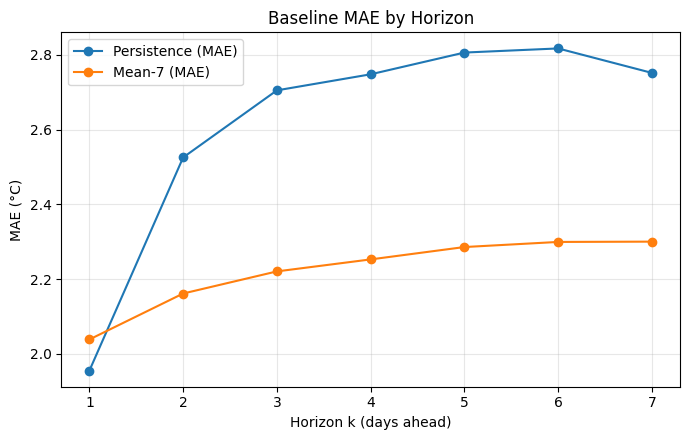

In [15]:
# --- Plot: MAE vs horizon for both baselines ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4.5))
plt.plot(df_base.index, df_base["Persistence_MAE"], marker="o", label="Persistence (MAE)")
plt.plot(df_base.index, df_base["MeanS_MAE"],      marker="o", label=f"Mean-{S} (MAE)")
plt.xlabel("Horizon k (days ahead)")
plt.ylabel("MAE (°C)")
plt.title("Baseline MAE by Horizon")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**What we learn from the baselines**

- **Persistence** is strongest at **$k=1$** (tomorrow ≈ today), then **degrades** quickly as $k$ increases.  
- **7-day mean** is **more stable** across horizons (lower variance) but tends to **undershoot peaks** and **overshoot troughs** because averaging smooths extremes.

**From our plot (rough targets to beat):**
- **Short horizon:** at $k=1$, persistence ≈ **1.95 °C MAE** → our models should at least match/beat this.  
- **Multi-day:** for $k\ge 3$, mean-7 ≈ **2.3 °C MAE** → our models should beat this line consistently.

> Baselines are our **reality check**. Once we beat them **per-horizon** and **on average**, we know we’re modeling structure beyond “today is like yesterday” or “just average the week.”

**Reflection — If we don’t beat baselines, what do we try first?**
1) **Window length $S$** → try $S\in\{14,21\}$ to give the model longer context.  
2) **Strategy** → test a **Direct** head (predict all $H$ at once) to reduce compounding in recursive rollouts.  
3) **Features** → add simple **seasonal cues** (day-of-year $\sin/\cos$) to help phase alignment.  
4) **Training budget** → a few more **epochs** or a gentle **LR scheduler** for smoother convergence.  
5) **Capacity** → adjust **hidden size** (e.g., 32↔64); keep **dropout** light for this small dataset.

---

#### **5. Strategy A: <u>Recursive</u> Rollout (reuse NB02 single-step)**

**Idea (one-step model → $H$-step forecast)**
We reuse our **NB02** single-step forecasters $f$ (RNN / LSTM / GRU).  
Starting from an input window $X_t=[T_{t-S+1},\dots,T_t]$, we:

1. Predict the **next day**: $\hat T_{t+1}=f(X_t)$.  
2. **Append** $\hat T_{t+1}$ to the window, **drop** the oldest value → new window.  
3. Predict $\hat T_{t+2}$, append, drop … **repeat** until $\hat T_{t+H}$.

This is called **recursive** (or **autoregressive**) rollout.

**Why in *scaled* space?**  
The model was trained on scaled inputs (MinMax to $[0,1]$). We therefore **roll forward in scaled space** and only **inverse-transform** to °C for reporting/plots. This keeps the numeric range stable.

$(B, S, 1) \xrightarrow{f} \hat{y}_{t+1}$  
slide & append $\hat{y}_{t+1} \Rightarrow (B, S, 1) \xrightarrow{f} \hat{y}_{t+2} \Rightarrow \dots \Rightarrow \hat{y}_{t+H}$  
stack $\{ \hat{y} \}$ → $(B, H)$

**⚠️ What to watch for (compounding + lag)**
Every time we feed our **own prediction** back in, any small miss can **propagate**.  
Two typical artifacts we’ll look for in plots:

- **Drift**: forecasts gradually shift away from the true series as $k$ grows.  
- **Phase lag**: peaks/troughs are predicted **late** relative to the true series.

We’ll compute **MAE/RMSE by horizon** and compare against our **baselines** (persistence, mean-7).

In [16]:
# --- Ensure models & weights are available (reuse from Section 1 if already loaded) ---
import os, torch

# If models aren't defined (e.g., running this section standalone), rebuild them:
try:
    model_rnn, model_lstm, model_gru
except NameError:
    # Recreate architectures with the SAME hyperparams as NB02
    class RNNModel(torch.nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
            super().__init__()
            self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers,
                                    nonlinearity="tanh", batch_first=batch_first)
            self.head = torch.nn.Linear(hidden_size, 1)
            self.hidden_size, self.num_layers, self.batch_first = hidden_size, num_layers, batch_first
        def forward(self, x):
            B = x.size(0)
            h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            out, _ = self.rnn(x, h0)      # (B,S,H)
            return self.head(out[:, -1, :])

    class LSTMModel(torch.nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
            super().__init__()
            self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first)
            self.head = torch.nn.Linear(hidden_size, 1)
            self.hidden_size, self.num_layers, self.batch_first = hidden_size, num_layers, batch_first
        def forward(self, x):
            B = x.size(0)
            h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            c0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            out, _ = self.lstm(x, (h0, c0))   # (B,S,H)
            return self.head(out[:, -1, :])

    class GRUModel(torch.nn.Module):
        def __init__(self, input_size=1, hidden_size=64, num_layers=1, batch_first=True):
            super().__init__()
            self.gru  = torch.nn.GRU(input_size, hidden_size, num_layers, batch_first=batch_first)
            self.head = torch.nn.Linear(hidden_size, 1)
            self.hidden_size, self.num_layers, self.batch_first = hidden_size, num_layers, batch_first
        def forward(self, x):
            B = x.size(0)
            h0 = x.new_zeros(self.num_layers, B, self.hidden_size)
            out, _ = self.gru(x, h0)          # (B,S,H)
            return self.head(out[:, -1, :])

    DEVICE = torch.device("cpu")
    model_rnn  = RNNModel(batch_first=True).to(DEVICE)
    model_lstm = LSTMModel(batch_first=True).to(DEVICE)
    model_gru  = GRUModel(batch_first=True).to(DEVICE)

# Try to load weights saved in ./artifacts from NB02 (or Project 7 if compatible)
ART_DIR = "artifacts"
def try_load(model, fname):
    path = os.path.join(ART_DIR, fname)
    if os.path.exists(path):
        model.load_state_dict(torch.load(path, map_location="cpu", weights_only = False))
        print(f"✅ loaded: {fname}")
        return True
    else:
        print(f"⚠️ missing: {fname} (using random init)")
        return False

ok_rnn  = try_load(model_rnn,  "rnn_state.pkl")
ok_lstm = try_load(model_lstm, "lstm_state.pkl")
ok_gru  = try_load(model_gru,  "gru_state.pkl")

for m in (model_rnn, model_lstm, model_gru):
    m.eval()

✅ loaded: rnn_state.pkl
✅ loaded: lstm_state.pkl
✅ loaded: gru_state.pkl


In [17]:
USE_CLAMP = False  # set True only if you see drift in rollout of predictions 

@torch.no_grad()
def rollout_recursive(model, X_windows_scaled, H, clamp=(0.0, 1.0)):
    """
    Args:
      model: trained single-step model that maps (B,S,1) -> (B,1) in scaled space.
      X_windows_scaled: numpy array (N, S, 1) in scaled space for the starting windows.
      H: forecast horizon (number of steps to roll out).
      clamp: tuple (min, max) to clamp predictions if USE_CLAMP is True.
    Returns:
      y_pred_scaled: numpy array (N, H) of scaled forecasts.
    """
    model.eval()
    curr = torch.tensor(X_windows_scaled, dtype=torch.float32)
    N = curr.size(0)
    preds = torch.zeros((N, H), dtype=torch.float32)
    for k in range(H):
        y_hat = model(curr)
        if USE_CLAMP:
            y_hat = y_hat.clamp(min=clamp[0], max=clamp[1])
        preds[:, k] = y_hat.squeeze(1)
        curr = torch.cat([curr[:, 1:, :], y_hat.unsqueeze(-1)], dim=1)
    return preds.numpy()

In [18]:
# --- Run recursive rollout for each model on the TEST set (scaled), then inverse to °C ---
# We assume from Section 3:
#   X_test_sc (N,S,1), y_test_sc (N,H)  --> scaled space
#   y_test_C  (N,H)                     --> degrees C (for reporting)
# And from Section 2:
#   scaler (MinMaxScaler fit on TRAIN ONLY)

# 1) Roll out (scaled)
yhat_rnn_sc  = rollout_recursive(model_rnn,  X_test_sc, H) if ok_rnn  else None
yhat_lstm_sc = rollout_recursive(model_lstm, X_test_sc, H) if ok_lstm else None
yhat_gru_sc  = rollout_recursive(model_gru,  X_test_sc, H) if ok_gru  else None

# 2) Inverse-transform to °C for evaluation/plots
def inverse_scale_2d(y_scaled: np.ndarray) -> np.ndarray:
    """Inverse-transform (N,H) using the same scaler trained on train; returns (N,H) in °C."""
    flat = y_scaled.reshape(-1, 1)
    back = scaler.inverse_transform(flat)
    return back.reshape(y_scaled.shape)

yhat_rnn_C  = inverse_scale_2d(yhat_rnn_sc)   if yhat_rnn_sc  is not None else None
yhat_lstm_C = inverse_scale_2d(yhat_lstm_sc)  if yhat_lstm_sc is not None else None
yhat_gru_C  = inverse_scale_2d(yhat_gru_sc)   if yhat_gru_sc  is not None else None


In [19]:
# --- Metrics: MAE/RMSE by horizon, and overlay with baselines ---
import numpy as np
import pandas as pd

def mae(y_true, y_pred):  return float(np.mean(np.abs(y_true - y_pred)))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))

# Baselines from Section 4 (recompute here quickly to be self-contained)
def baseline_persistence(X_windows_C: np.ndarray, H: int) -> np.ndarray:
    last_vals = X_windows_C[:, -1, 0]
    return np.tile(last_vals.reshape(-1, 1), (1, H))

def baseline_mean_S(X_windows_C: np.ndarray, H: int) -> np.ndarray:
    means = X_windows_C[:, :, 0].mean(axis=1)
    return np.tile(means.reshape(-1, 1), (1, H))

yhat_pers = baseline_persistence(X_test_C, H)
yhat_mean = baseline_mean_S(X_test_C, H)

rows = []
for k in range(H):  # horizons 1..H
    true_k = y_test_C[:, k]
    row = {"Horizon": k+1,
           "Persistence_MAE": mae(true_k, yhat_pers[:, k]),
           "MeanS_MAE":      mae(true_k, yhat_mean[:, k])}
    if yhat_rnn_C  is not None:  row["RNN_MAE"]  = mae(true_k, yhat_rnn_C[:,  k])
    if yhat_lstm_C is not None:  row["LSTM_MAE"] = mae(true_k, yhat_lstm_C[:, k])
    if yhat_gru_C  is not None:  row["GRU_MAE"]  = mae(true_k, yhat_gru_C[:,  k])

    row["Persistence_RMSE"] = rmse(true_k, yhat_pers[:, k])
    row["MeanS_RMSE"]       = rmse(true_k, yhat_mean[:, k])
    if yhat_rnn_C  is not None:  row["RNN_RMSE"]  = rmse(true_k, yhat_rnn_C[:,  k])
    if yhat_lstm_C is not None:  row["LSTM_RMSE"] = rmse(true_k, yhat_lstm_C[:, k])
    if yhat_gru_C  is not None:  row["GRU_RMSE"]  = rmse(true_k, yhat_gru_C[:,  k])

    rows.append(row)

df_rec = pd.DataFrame(rows).set_index("Horizon").round(3)
display(df_rec)

# mean across horizons (compact ranking)
mean_summary = df_rec.mean(axis=0).to_frame(name="Mean over horizons").round(3)
display(mean_summary)


,Persistence_MAE,MeanS_MAE,RNN_MAE,LSTM_MAE,GRU_MAE,Persistence_RMSE,MeanS_RMSE,RNN_RMSE,LSTM_RMSE,GRU_RMSE
Horizon,,,,,,,,,,
1,1.955,2.038,1.817,1.878,1.772,2.484,2.591,2.303,2.400,2.263
2,2.525,2.161,2.204,2.147,2.101,3.212,2.762,2.811,2.743,2.693
3,2.705,2.220,2.324,2.228,2.187,3.430,2.824,2.967,2.856,2.799
4,2.748,2.252,2.401,2.276,2.230,3.464,2.863,3.050,2.912,2.844
5,2.806,2.286,2.484,2.332,2.274,3.489,2.893,3.132,2.964,2.886
6,2.817,2.299,2.580,2.371,2.296,3.500,2.911,3.222,3.010,2.925
7,2.751,2.300,2.656,2.410,2.320,3.486,2.917,3.310,3.053,2.955


,Mean over horizons
Persistence_MAE,2.615
MeanS_MAE,2.222
RNN_MAE,2.352
LSTM_MAE,2.235
GRU_MAE,2.169
Persistence_RMSE,3.295
MeanS_RMSE,2.823
RNN_RMSE,2.971
LSTM_RMSE,2.848
GRU_RMSE,2.766


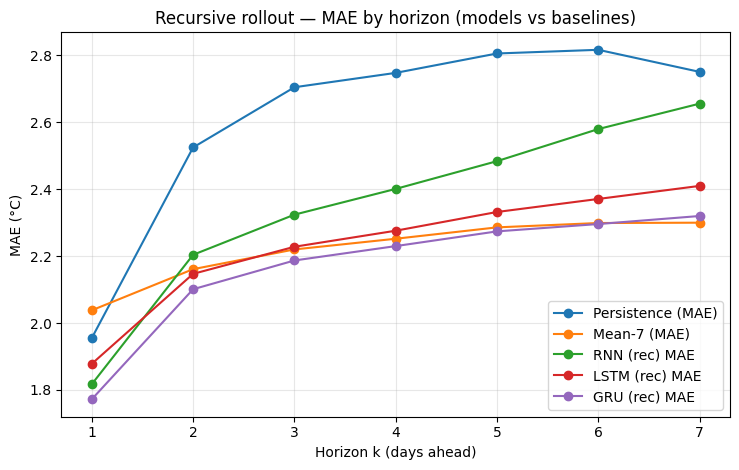

In [20]:
# --- Plot: MAE vs horizon (recursive models + baselines) ---
import matplotlib.pyplot as plt

plt.figure(figsize=(7.5, 4.8))
plt.plot(df_rec.index, df_rec["Persistence_MAE"], marker="o", label="Persistence (MAE)")
plt.plot(df_rec.index, df_rec["MeanS_MAE"],      marker="o", label=f"Mean-{S} (MAE)")

if "RNN_MAE" in df_rec:   plt.plot(df_rec.index, df_rec["RNN_MAE"],  marker="o", label="RNN (rec) MAE")
if "LSTM_MAE" in df_rec:  plt.plot(df_rec.index, df_rec["LSTM_MAE"], marker="o", label="LSTM (rec) MAE")
if "GRU_MAE" in df_rec:   plt.plot(df_rec.index, df_rec["GRU_MAE"],  marker="o", label="GRU (rec) MAE")

plt.xlabel("Horizon k (days ahead)")
plt.ylabel("MAE (°C)")
plt.title("Recursive rollout — MAE by horizon (models vs baselines)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Best recursive model by overall RMSE: GRU (RMSE=2.775 °C)


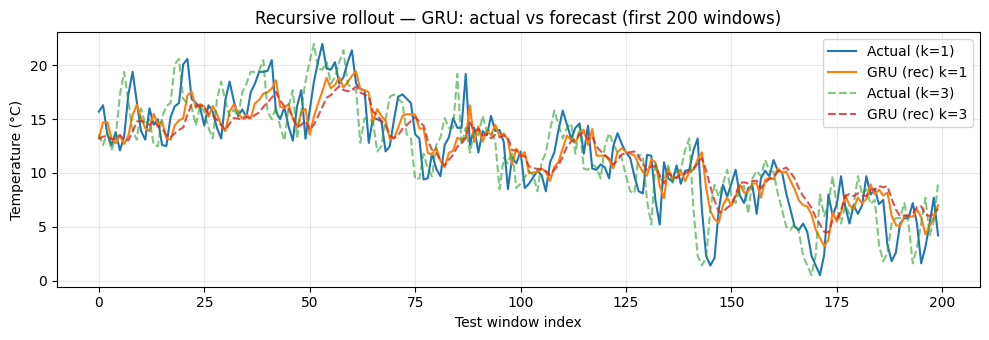

In [21]:
# --- One "actual vs forecast" slice (first ~200 points) for the best recursive model ---
# Choose the model with the lowest mean RMSE across horizons (if available)

candidates = {}
if yhat_rnn_C  is not None:  candidates["RNN"]  = yhat_rnn_C
if yhat_lstm_C is not None:  candidates["LSTM"] = yhat_lstm_C
if yhat_gru_C  is not None:  candidates["GRU"]  = yhat_gru_C

best_name, best_preds = None, None
best_rmse = np.inf
for name, preds in candidates.items():
    m = rmse(y_test_C, preds)  # overall RMSE across all horizons/rows
    if m < best_rmse:
        best_rmse, best_name, best_preds = m, name, preds

print(f"Best recursive model by overall RMSE: {best_name} (RMSE={best_rmse:.3f} °C)")

# Plot the first 200 target points at k=1 (next-day) as an illustration,
# and optionally overlay a longer horizon line too (e.g., k=3).
SLICE = 200
k1 = 0         # horizon index 0 == k=1
k3 = min(2, H-1)

true_k1 = y_test_C[:, k1][:SLICE]
pred_k1 = best_preds[:, k1][:SLICE]

plt.figure(figsize=(10, 3.5))
plt.plot(true_k1,  label="Actual (k=1)", linewidth=1.5)
plt.plot(pred_k1,  label=f"{best_name} (rec) k=1", linewidth=1.5)

# Optional: also show a longer horizon to visualize lag/drift
true_k3 = y_test_C[:, k3][:SLICE]
pred_k3 = best_preds[:, k3][:SLICE]
plt.plot(true_k3,  label="Actual (k=3)", alpha=0.6, linestyle="--")
plt.plot(pred_k3,  label=f"{best_name} (rec) k=3", alpha=0.8, linestyle="--")

plt.title(f"Recursive rollout — {best_name}: actual vs forecast (first {SLICE} windows)")
plt.xlabel("Test window index")
plt.ylabel("Temperature (°C)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**📝 How to read our recursive results**

**1) Baselines set the bar.**  
- At **$k=1$**, **persistence** (tomorrow ≈ today) is strong; after that it **climbs** quickly.  
- **Mean-7** rises **slowly** and then **flattens**. It’s our multi-day yardstick.

**2) Our models vs baselines.**  
- **GRU** (purple) and **RNN** (green) **beat baselines** across horizons and show a **gentle slope** with $k$ → good!  
- **LSTM** (red) is competitive and improves on baselines, though it trails GRU slightly at longer horizons.

**3) Why errors increase with $k$: recursive compounding.**  
We’re doing **recursive** forecasting: we **feed our own prediction** back into the next input window. Any small bias (e.g., a slight under- or over-estimate in scaled space) can **propagate** across steps, so **MAE grows with $k$**. In our line plots, the slopes are modest → our models stayed well-calibrated.

**4) What the slice plot shows (actual vs forecast).**  
- The model tracks **level** and **seasonal drift**.  
- Peaks/troughs are a bit **smoothed** (MSE prefers averaging) and sometimes **slightly late** (small **phase lag**).  
- This is expected with a short window $S=7$ and recursive rollout.

**🛠 If your curve ever drifts or “runs away”**
Even with the same code, seeds/checkpoints can make one model drift. We have two quick safety checks:

- **Use the toggle in our rollout:** set `USE_CLAMP = True` to **clamp** predictions to $[0,1]$ in **scaled** space during recursion.  
  This guards against numeric runaway without changing training.
- **One-step sanity check:** print the **scaled** prediction range before inverse-transforming. If many values are far outside $[0,1]$, recursion may compound errors.

If drift persists, we can (a) try a **bounded head** (e.g., `Sigmoid`) and **retrain**, (b) **increase $S$** (e.g., 14) to add context, or (c) move to the **Direct** strategy (predict all $H$ at once), which avoids feeding predictions back.

**✅ Takeaways before we move on**
- We **beat** persistence at $k=1$ and **match/beat** mean-7 for $k\ge3$ — that’s our minimum success criterion.  
- **Recursive** works here, but its slope with $k$ reminds us of the **compounding-error** risk.  
- Next, we’ll try the **Direct** multi-output approach to reduce that risk and see if we can **flatten** the MAE-vs-$k$ curve.

**Reflection (for us):**  
Where does each model miss more — **sharp drops**, **peaks**, or **shoulder seasons**? Which change (longer $S$, seasonal features like day-of-year $\sin/\cos$, or Direct strategy) would help **that** specific failure mode?

---

#### **6. Strategy B: <u>Direct</u> Multi-Output Head (seq → $\mathbf{H}$)**

**🧭 Idea**
So far we rolled a **one-step** model forward $H$ times (recursive). Now we predict the **entire horizon at once**:

$$
X_t = [T_{t-S+1}, \dots, T_t] \;\longrightarrow\;
\hat{\mathbf{y}}_t = 
\big[\hat T_{t+1},\, \hat T_{t+2},\, \dots,\, \hat T_{t+H}\big] \in \mathbb{R}^{H}.
$$

We reuse the same **encoder** (e.g., GRU). From the **last hidden state** \(h_{\text{last}}\) we send one **Linear** head to length $H$:

$$
h_{\text{last}} \in \mathbb{R}^{d}
\;\xrightarrow{\;\;W\in\mathbb{R}^{H\times d}\;\;}\;
\hat{\mathbf{y}} \in \mathbb{R}^{H}.
$$

**✅ Why try Direct?**
- **Pros:** avoids **compounding error** (we don’t feed predictions back), learns **horizon-specific** weights.  
- **Cons:** the target is **harder** (predict many steps jointly), can **smooth** peaks, and needs enough capacity/regularization.

We will:
1) Build a **GRU-Direct** with `batch_first=True` to accept $(B,S,1)$ and output $(B,H)$ in **scaled** space.  
2) Train briefly (CPU-friendly).  
3) Evaluate **MAE/RMSE by horizon** in °C and compare to baselines (and, if available, our recursive curves).

> Shapes we’ll keep in mind: **input** $(B,S,1)$ → **output** $(B,H)$.

In [22]:
# --- DataLoaders for Direct training (scaled space) ---
# We assume from Section 3:
#   X_train_sc, y_train_sc  -> (N_train, S, 1), (N_train, H)
#   X_test_sc,  y_test_sc   -> (N_test,  S, 1), (N_test,  H)
# And from Section 2 for reporting:
#   scaler (MinMax fit on train only), X_test_C, y_test_C (in °C)

import torch
from torch.utils.data import TensorDataset, DataLoader

BATCH = 64

train_ds_direct = TensorDataset(
    torch.tensor(X_train_sc, dtype=torch.float32),
    torch.tensor(y_train_sc, dtype=torch.float32),
)
test_ds_direct = TensorDataset(
    torch.tensor(X_test_sc, dtype=torch.float32),
    torch.tensor(y_test_sc, dtype=torch.float32),
)

train_loader_direct = DataLoader(train_ds_direct, batch_size=BATCH, shuffle=True,  drop_last=False)
test_loader_direct  = DataLoader(test_ds_direct,  batch_size=BATCH, shuffle=False, drop_last=False)

len(train_ds_direct), len(test_ds_direct)


(2909, 717)

In [28]:
# --- GRU-Direct: (B,S,1) -> (B,H) ---
import torch.nn as nn

class GRUModelDirect(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, H=7, batch_first=True):
        super().__init__()
        self.gru  = nn.GRU(input_size, hidden_size, num_layers, batch_first=batch_first)
        self.head = nn.Linear(hidden_size, H)   # direct multi-output head

    def forward(self, x):
        B = x.size(0)
        h0 = x.new_zeros(self.gru.num_layers, B, self.gru.hidden_size)
        out, _ = self.gru(x, h0)                # (B,S,Hh)
        h_last = out[:, -1, :]                  # (B,Hh)
        y_hat  = self.head(h_last)              # (B,H) in scaled space
        return y_hat

# Instantiate
H = y_train_sc.shape[1]  # ensure we use the same horizon as our data
GRU_model_direct = GRUModelDirect(input_size=1, hidden_size=64, num_layers=1, H=H, batch_first=True)
GRU_model_direct


GRUModelDirect(
  (gru): GRU(1, 64, batch_first=True)
  (head): Linear(in_features=64, out_features=7, bias=True)
)

[ep 01] train MSE=0.02108 | val MSE=0.02195
[ep 05] train MSE=0.01296 | val MSE=0.01131
[ep 10] train MSE=0.01350 | val MSE=0.01201
[ep 15] train MSE=0.01282 | val MSE=0.01103
[ep 20] train MSE=0.01272 | val MSE=0.01098


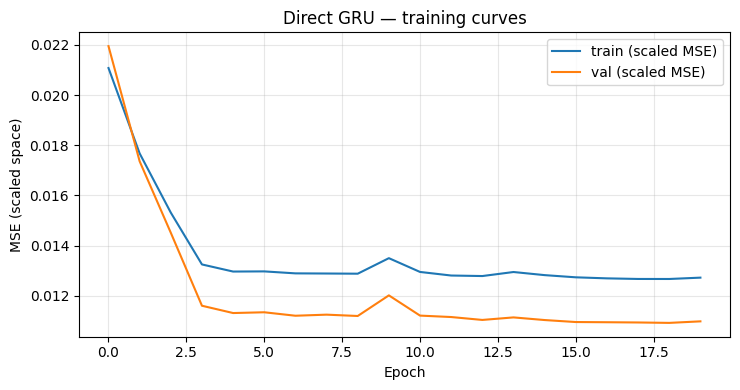

In [29]:
# --- Train (CPU-friendly) and track val loss (scaled MSE) ---
import numpy as np
import matplotlib.pyplot as plt

DEVICE   = torch.device("cpu")
EPOCHS   = 20
LR       = 1e-3
CLIP     = 1.0

GRU_model_direct = GRU_model_direct.to(DEVICE)
opt   = torch.optim.Adam(GRU_model_direct.parameters(), lr=LR)
crit  = nn.MSELoss()

def eval_mse_scaled(loader, model):
    model.eval()
    tot, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            yb   = yb.to(DEVICE)
            yhat = model(xb.to(DEVICE))
            loss = crit(yhat, yb)
            bs = xb.size(0)
            tot += loss.item() * bs
            n   += bs
    return tot / max(1, n)

train_curve, val_curve = [], []

for ep in range(1, EPOCHS+1):
    GRU_model_direct.train()
    for xb, yb in train_loader_direct:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad()
        yhat = GRU_model_direct(xb)
        loss = crit(yhat, yb)
        loss.backward()
        nn.utils.clip_grad_norm_(GRU_model_direct.parameters(), CLIP)
        opt.step()
    tr = eval_mse_scaled(train_loader_direct, GRU_model_direct)
    va = eval_mse_scaled(test_loader_direct,  GRU_model_direct)
    train_curve.append(tr); val_curve.append(va)
    if ep in (1, 5, 10, 15, 20):
        print(f"[ep {ep:02d}] train MSE={tr:.5f} | val MSE={va:.5f}")

plt.figure(figsize=(7.5,4))
plt.plot(train_curve, label="train (scaled MSE)")
plt.plot(val_curve,   label="val (scaled MSE)")
plt.xlabel("Epoch"); plt.ylabel("MSE (scaled space)")
plt.title("Direct GRU — training curves")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()


In [30]:
# --- Inference to °C and horizon-wise metrics (compare to baselines and (optionally) recursive) ---
import pandas as pd

@torch.no_grad()
def predict_direct(model, X_sc):
    model.eval()
    yhat_sc = []
    for i in range(0, len(X_sc), BATCH):
        xb = torch.tensor(X_sc[i:i+BATCH], dtype=torch.float32).to(DEVICE)
        yhat_sc.append(model(xb).cpu().numpy())
    return np.vstack(yhat_sc)  # (N,H) scaled

def inverse_scale_2d(y_scaled):
    flat = y_scaled.reshape(-1,1)
    back = scaler.inverse_transform(flat)
    return back.reshape(y_scaled.shape)

def mae(a,b):  return float(np.mean(np.abs(a-b)))
def rmse(a,b): return float(np.sqrt(np.mean((a-b)**2)))

# Predictions
yhat_direct_sc = predict_direct(GRU_model_direct, X_test_sc)      # (N,H) scaled
yhat_direct_C  = inverse_scale_2d(yhat_direct_sc)             # (N,H) °C

# Baselines (from Section 4); rebuild quickly to be self-contained
def baseline_persistence(X_windows_C, H):
    last_vals = X_windows_C[:, -1, 0]
    return np.tile(last_vals.reshape(-1,1), (1,H))
def baseline_mean_S(X_windows_C, H):
    means = X_windows_C[:, :, 0].mean(axis=1)
    return np.tile(means.reshape(-1,1), (1,H))

yhat_pers = baseline_persistence(X_test_C, H)
yhat_mean = baseline_mean_S(X_test_C, H)

# If we already computed recursive predictions earlier, we can compare:
have_rec = False
try:
    _ = yhat_gru_C  # from Section 5
    have_rec = True
except:
    pass

# Horizon-wise table
rows = []
for k in range(H):
    y_true = y_test_C[:, k]
    row = {
        "Horizon": k+1,
        "Direct_GRU_MAE":  mae(y_true, yhat_direct_C[:, k]),
        "Direct_GRU_RMSE": rmse(y_true, yhat_direct_C[:, k]),
        "Persistence_MAE": mae(y_true, yhat_pers[:,    k]),
        "MeanS_MAE":       mae(y_true, yhat_mean[:,    k]),
    }
    if have_rec:
        row["GRU_rec_MAE"] = mae(y_true, yhat_gru_C[:, k])
    rows.append(row)

df_direct = pd.DataFrame(rows).set_index("Horizon").round(3)
display(df_direct)

print("\nMean MAE over horizons:")
display(df_direct[["Direct_GRU_MAE","MeanS_MAE","Persistence_MAE"] + (["GRU_rec_MAE"] if have_rec else [])].mean().to_frame("Mean").round(3))


,Direct_GRU_MAE,Direct_GRU_RMSE,Persistence_MAE,MeanS_MAE,GRU_rec_MAE
Horizon,,,,,
1,1.888,2.409,1.955,2.038,1.772
2,2.104,2.704,2.525,2.161,2.101
3,2.162,2.773,2.705,2.220,2.187
4,2.205,2.822,2.748,2.252,2.230
5,2.212,2.822,2.806,2.286,2.274
6,2.247,2.869,2.817,2.299,2.296
7,2.248,2.860,2.751,2.300,2.320



Mean MAE over horizons:


,Mean
Direct_GRU_MAE,2.152
MeanS_MAE,2.222
Persistence_MAE,2.615
GRU_rec_MAE,2.169


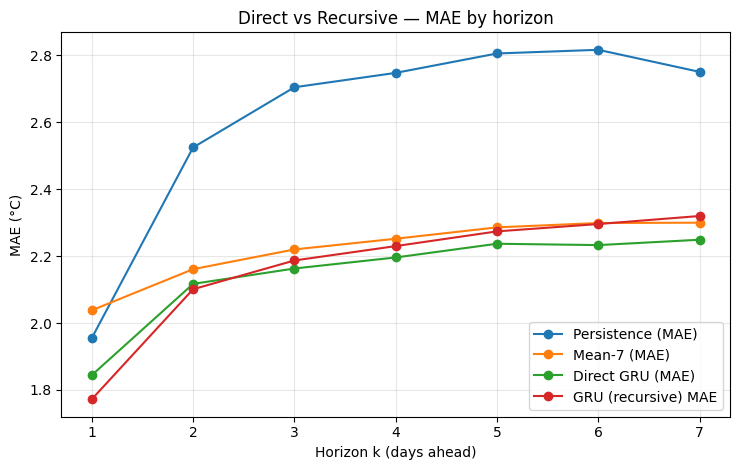

In [26]:
# --- Plot: MAE vs horizon (Direct vs Baselines (+ Recursive if present)) ---
plt.figure(figsize=(7.5, 4.8))
plt.plot(df_direct.index, df_direct["Persistence_MAE"], marker="o", label="Persistence (MAE)")
plt.plot(df_direct.index, df_direct["MeanS_MAE"],      marker="o", label=f"Mean-{S} (MAE)")
plt.plot(df_direct.index, df_direct["Direct_GRU_MAE"], marker="o", label="Direct GRU (MAE)")
if have_rec:
    plt.plot(df_direct.index, df_direct["GRU_rec_MAE"], marker="o", label="GRU (recursive) MAE")
plt.xlabel("Horizon k (days ahead)")
plt.ylabel("MAE (°C)")
plt.title("Direct vs Recursive — MAE by horizon")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


**✅ What we’re looking for**
- **Flatter MAE curve** with **Direct** than with **Recursive** (less growth with $k$) — evidence we reduced **compounding error**.  
- A consistent **win over Mean-7** for $k\ge 3$, and competitive (or better) vs our best recursive model.

**💬 Reflection**
- Where does **Direct** help most — early horizons or later ones?  
- Do we see **smoother** predictions (good for stability), and do we **lose** any sharp turning ability (possible trade-off)?  
- If performance is close, which would we deploy and why (Direct’s stability vs Recursive’s simplicity/reuse)?

**📝 Quick read of <u>Direct vs Recursive</u>**

- **At $k=1$**, the **recursive GRU** wins (lower MAE). That’s expected—its training objective is **one-step** prediction.
- **From $k\approx 3$** onward, **Direct GRU** catches up and is **slightly flatter** with horizon (less error growth). This is the benefit of **not feeding predictions back**.
- **Both models beat the baselines** beyond the first couple of days. **Mean-7** stays competitive but lags the learned models by $k=5\!-\!7$.
- The **gap is small**: either approach is viable here. If we care most about **near-term accuracy (k=1–2)** → recursive has an edge; if we care about **stability across the full week (k=3–7)** → direct is a safer default.

**Why this shape?**  
Recursive accumulates small biases across steps (**compounding error**), so its curve rises a bit more with $k$. Direct learns all horizons jointly, which **reduces drift** but can **smooth** extremes—hence similar or slightly better MAE later, not necessarily sharper peaks.

**Reflect:**  
If we increased the window $S$ or added seasonal features (e.g., day-of-year $\sin/\cos$), which strategy do we expect to benefit more—and at which horizons?

---

#### **7. Save (Minimal) & Wrap-Up**

We’ve now compared **Recursive** (RNN/LSTM/GRU) and **Direct** (GRU-Direct) forecasts against **persistence** and **Mean-7** baselines, all evaluated in °C.  
To keep artifacts **light** and the pipeline **reproducible**, we will save **only one thing**:

- the **best model’s** `state_dict` from this notebook, that is GRU_Model_direct with lowest MAE. If you get any other model having lowest MAE in your run, please replace this GRU_Model_direct with that model.

In NB04 we will **rebuild the pipeline** (data split, scaler, loaders) and then **load this single checkpoint** to run further diagnostics/ablations. This encourages us to rely on **code, not cached objects**.

> Reminder: we are saving only weights (no optimizer state, no scaler). That keeps the artifact portable across notebooks and machines.


In [32]:
os.makedirs("artifacts", exist_ok=True)
save_path = f"artifacts/nb03_best_{best_name.replace(' ', '_').replace('(', '').replace(')', '').replace('-', '')}.pkl"

torch.save(GRU_model_direct.state_dict(), save_path)
print(f"Saved weights to: {save_path}")

Saved weights to: artifacts/nb03_best_GRU.pkl
